# Интуиция по коэффициентам корреляции

Этот ноутбук показывает, как выглядят разные значения коэффициента корреляции на синтетических данных и временных рядах. Также он демонстрирует различие между Pearson и Spearman и подводные камни, когда связь нелинейная.

In [2]:
# Imports and configuration (comments are in English by your request)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)

def generate_correlated(n=500, rho=0.8, mean=None, std=None):
    """Generate two normally distributed variables (X, Y) with target Pearson rho.
    Uses Cholesky factorization on a 2x2 covariance matrix.
    """
    if mean is None:
        mean = np.array([0.0, 0.0])
    if std is None:
        std = np.array([1.0, 1.0])
    cov = np.array([[1.0, rho], [rho, 1.0]])
    L = np.linalg.cholesky(cov)
    z = np.random.randn(2, n)
    xy = (L @ z).T
    xy = xy * std + mean
    x, y = xy[:, 0], xy[:, 1]
    return x, y

def pearson_spearman(x, y):
    """Compute Pearson and Spearman correlations using NumPy/Pandas only."""
    pearson = np.corrcoef(x, y)[0, 1]
    # Spearman via ranks
    xr = pd.Series(x).rank(method="average").to_numpy()
    yr = pd.Series(y).rank(method="average").to_numpy()
    spearman = np.corrcoef(xr, yr)[0, 1]
    return float(pearson), float(spearman)

def plot_scatter(x, y, title_prefix=""):
    """Scatter plot with Pearson and Spearman in title."""
    p, s = pearson_spearman(x, y)
    plt.figure()
    plt.scatter(x, y, alpha=0.6)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(f"{title_prefix} Pearson={p:.3f}, Spearman={s:.3f}")
    plt.show()

def plot_timeseries(x, y, title_prefix=""):
    """Plot X and Y as time series to see alignment visually."""
    p, s = pearson_spearman(x, y)
    t = np.arange(len(x))
    plt.figure()
    plt.plot(t, x, label="X")
    plt.plot(t, y, label="Y")
    plt.xlabel("t")
    plt.ylabel("value")
    plt.legend()
    plt.title(f"{title_prefix} Pearson={p:.3f}, Spearman={s:.3f}")
    plt.show()

def demo_scatter_grid(rhos=(0.0, 0.2, 0.5, 0.8, 0.95, -0.5), n=500):
    """Generate and plot separate scatter charts for each target rho.
    (No subplots to respect the constraint: one chart per figure.)
    """
    for rho in rhos:
        x, y = generate_correlated(n=n, rho=rho)
        plot_scatter(x, y, title_prefix=f"Scatter (target rho {rho}) | ")

def demo_time_shifted_sin(n=600, phase_shift=np.pi/6, noise_std=0.2):
    """Create two sinusoids with a phase shift; Pearson depends on shift and noise."""
    t = np.linspace(0, 8*np.pi, n)
    x = np.sin(t) + np.random.randn(n)*noise_std
    y = np.sin(t + phase_shift) + np.random.randn(n)*noise_std
    # plot_scatter(x, y, title_prefix="Sine waves (phase-shift) | ")
    plot_timeseries(x, y, title_prefix="Sine waves (phase-shift) | ")

def demo_nonlinear_trap(n=600, noise_std=0.2):
    """Show a nonlinear relation where Pearson ~ 0 but variables are clearly related.
    Example: Y = X^2 + noise (symmetric X).
    """
    x = np.random.uniform(-2.5, 2.5, size=n)
    y = x**2 + np.random.randn(n)*noise_std
    plot_scatter(x, y, title_prefix="Nonlinear (parabolic) | ")

def demo_correlation_matrix(k=6, n=600):
    """Build a small family of signals and plot their correlation matrix as an image."""
    base = np.random.randn(n)
    cols = {}
    cols["base"] = base
    for i, rho in enumerate([0.95, 0.8, 0.5, 0.2, -0.5], start=1):
        noise = np.random.randn(n)
        y = rho*base + np.sqrt(1-rho**2)*noise
        cols[f"sig_{rho}"] = y
    df = pd.DataFrame(cols)
    corr = df.corr(method="pearson")
    plt.figure()
    plt.imshow(corr, interpolation="nearest")
    plt.xticks(ticks=np.arange(len(corr.columns)), labels=corr.columns, rotation=45, ha="right")
    plt.yticks(ticks=np.arange(len(corr.index)), labels=corr.index)
    plt.title("Correlation matrix (Pearson)")
    plt.colorbar()
    plt.tight_layout()
    plt.show()
    return corr

print("Ready: helper functions defined. Run the cells below for demos.")


Ready: helper functions defined. Run the cells below for demos.


## Быстрый старт
Запусти ячейку ниже: она покажет отдельные scatter-графики для разных целевых значений корреляции.

In [3]:
# Demo 1: scatter charts for several target correlations
#demo_scatter_grid(rhos=(0.0, 0.2, 0.5, 0.8, 0.95, -0.5), n=600)

## Временные ряды и фазовый сдвиг
Ниже — пример синусоид с фазовым сдвигом и шумом. Pearson меняется в зависимости от сдвига.

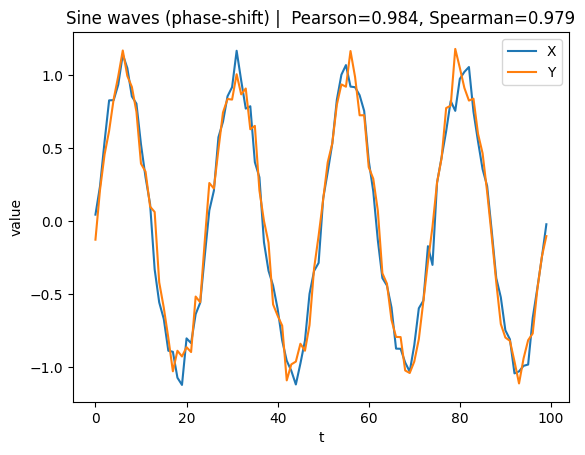

In [4]:
# Demo 2: time-shifted sine waves (adjust phase_shift and noise_std to experiment)
demo_time_shifted_sin(n=100, phase_shift=np.pi/4000, noise_std=0.09)

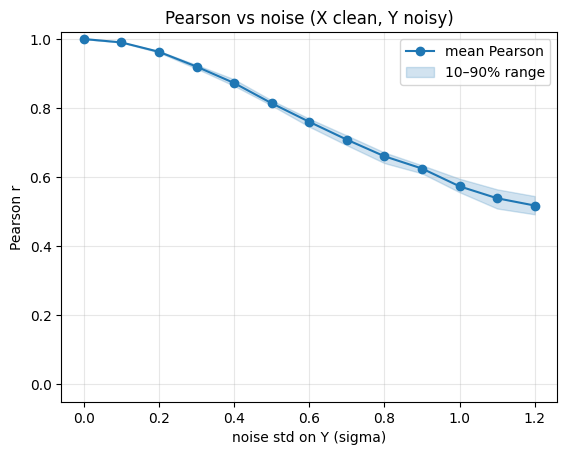

In [5]:
# Demo 2b: Pearson vs noise (noise added only to Y, no phase shift)
# X = sin(t), Y = sin(t) + N(0, sigma^2)

def pearson_vs_noise(n=600, noise_grid=None, repeats=10):
    if noise_grid is None:
        noise_grid = np.linspace(0.0, 1.0, 11)
    t = np.linspace(0, 8*np.pi, n)
    base = np.sin(t)
    means = []
    lows = []
    highs = []
    for sigma in noise_grid:
        vals = []
        for _ in range(repeats):
            x = base
            y = base + np.random.randn(n) * sigma
            p, _ = pearson_spearman(x, y)
            vals.append(p)
        vals = np.array(vals)
        means.append(vals.mean())
        lows.append(np.percentile(vals, 10))
        highs.append(np.percentile(vals, 90))
    means = np.array(means)
    lows = np.array(lows)
    highs = np.array(highs)

    plt.figure()
    plt.plot(noise_grid, means, marker='o', label='mean Pearson')
    plt.fill_between(noise_grid, lows, highs, color='C0', alpha=0.2, label='10–90% range')
    plt.xlabel('noise std on Y (sigma)')
    plt.ylabel('Pearson r')
    plt.ylim(-0.05, 1.02)
    plt.title('Pearson vs noise (X clean, Y noisy)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Try it:
pearson_vs_noise(n=800, noise_grid=np.linspace(0, 1.2, 13), repeats=12)

## Нелинейность: ловушка для Pearson
Корреляция Пирсона чувствительна к **линейной** связи. При нелинейной — может быть близка к 0.

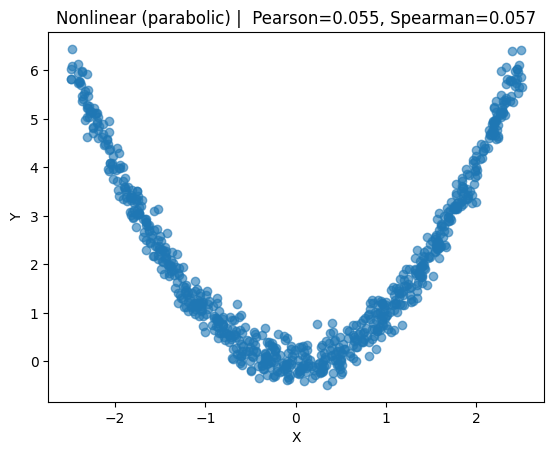

In [6]:
# Demo 3: nonlinear relation where Pearson ~ 0 but dependency is obvious
demo_nonlinear_trap(n=800, noise_std=0.25)

## Матрица корреляций (несколько сигналов)
Быстрый взгляд на матрицу корреляций для семейства сигналов, построенных от общего базового шума.

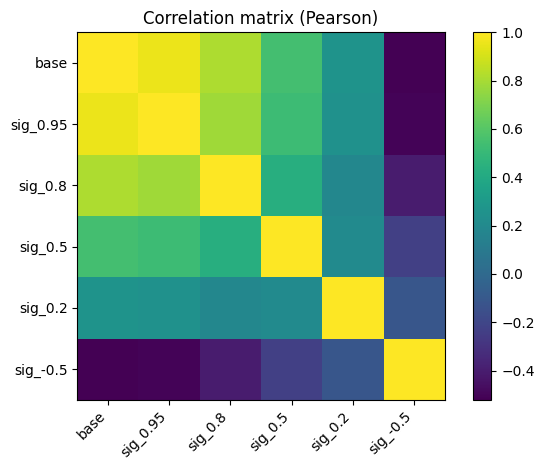

,base,sig_0.95,sig_0.8,sig_0.5,sig_0.2,sig_-0.5
base,1.000000,0.954351,0.813964,0.548206,0.261853,-0.519959
sig_0.95,0.954351,1.000000,0.780413,0.523734,0.248413,-0.506619
sig_0.8,0.813964,0.780413,1.000000,0.431042,0.182427,-0.401595
sig_0.5,0.548206,0.523734,0.431042,1.000000,0.205305,-0.230699
sig_0.2,0.261853,0.248413,0.182427,0.205305,1.000000,-0.111476
sig_-0.5,-0.519959,-0.506619,-0.401595,-0.230699,-0.111476,1.000000


In [7]:
# Demo 4: correlation matrix of several related signals
corr = demo_correlation_matrix(k=6, n=800)
corr

### Что можно менять
- В `demo_scatter_grid` поменять список `rhos` и размер выборки `n`.
- В `demo_time_shifted_sin` менять `phase_shift` и `noise_std`.
- В `demo_nonlinear_trap` менять `noise_std` и диапазон X.
- В `demo_correlation_matrix` добавить/изменить список `rho` (внутри функции).

## Зависимость корреляции Пирсона от уровня шума (без фазового сдвига)
Берём базовый сигнал s(t) = sin(t). X = s(t) — чистый базовый сигнал, а к Y добавляем независимый гауссов шум разной величины.
Для устойчивости усредняем корреляцию по нескольким прогонам. Чем больше шум, тем ниже ожидаемая корреляция.


### Сравнение X и нескольких реализаций Y при фиксированном уровне шума
Ниже можно визуально сравнить исходный X = sin(t) и несколько примеров Y = X + шум при выбранном σ. На графике также выводится Pearson для каждого примера.

Y ex1 (σ=0.20, r=0.957, rmse=0.209)
Y ex2 (σ=0.20, r=0.965, rmse=0.189)


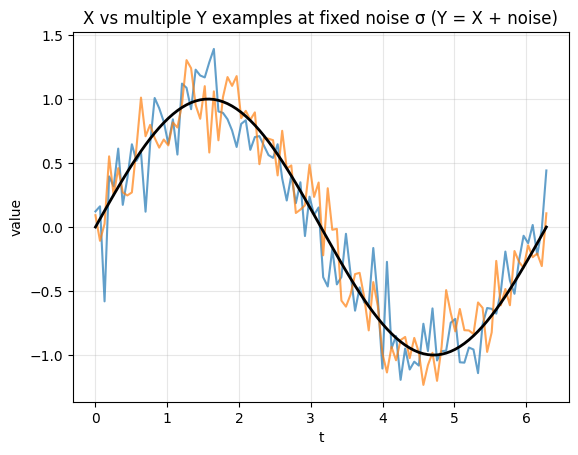

In [8]:
# Demo 2c: Compare X vs several Y examples at a chosen noise level (noise on Y only)


def compare_examples_at_noise(n=100, sigma=0.5, examples=3):
    t = np.linspace(0, (n/100)*2*np.pi, n)
    x = np.sin(t)
    plt.figure()
    for i in range(examples):
        y = x + np.random.randn(n) * sigma
        p, _ = pearson_spearman(x, y)
        rmse = float(np.sqrt(np.mean((y - x) ** 2)))
        plt.plot(t, y, alpha=0.7, label=f'Y ex{i+1} (σ={sigma:.2f}, r={p:.3f})')
        print(f'Y ex{i+1} (σ={sigma:.2f}, r={p:.3f}, rmse={rmse:.3f})')
    plt.plot(t, x, color='k', linewidth=2, label='X (clean)')
    plt.xlabel('t')
    plt.ylabel('value')
    plt.title('X vs multiple Y examples at fixed noise σ (Y = X + noise)')
    # plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Try it:
compare_examples_at_noise(n=100, sigma=0.2, examples=2)

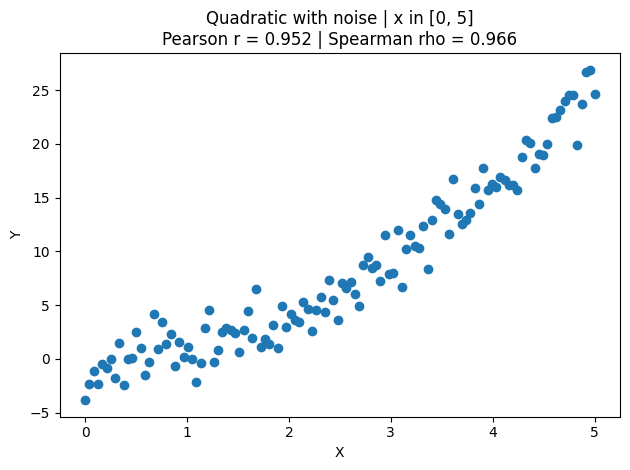

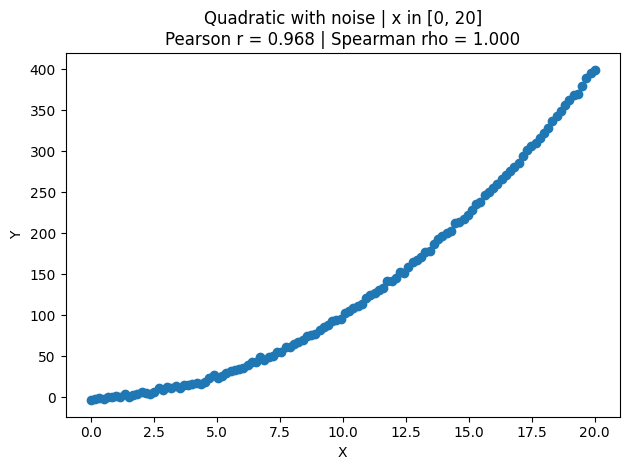

,Scenario,Pearson r,Spearman rho
0,"x in [0, 5]",0.951600,0.965998
1,"x in [0, 20]",0.967924,0.999632


In [15]:
# Explore impact of x-range on Pearson vs Spearman for y = x^2 + noise
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def rankdata_average_ties(x):
    x = np.asarray(x)
    order = np.argsort(x, kind="mergesort")
    ranks = np.empty_like(order, dtype=float)
    ranks[order] = np.arange(1, len(x) + 1)
    _, inverse, counts = np.unique(x, return_inverse=True, return_counts=True)
    for idx, count in enumerate(counts):
        if count > 1:
            tie_positions = np.where(inverse == idx)[0]
            mean_rank = ranks[tie_positions].mean()
            ranks[tie_positions] = mean_rank
    return ranks

def pearson_corr(x, y):
    return float(np.corrcoef(x, y)[0, 1])

def spearman_corr(x, y):
    rx = rankdata_average_ties(x)
    ry = rankdata_average_ties(y)
    return pearson_corr(rx, ry)

n = 120

# We'll use a fixed RNG so the noise is reproducible and identical across scenarios except for x-range.
rng_fixed = np.random.default_rng(20250809)

# Scenario A: Original range [0, 5]
x_a = np.linspace(0, 5, n)
noise_a = rng_fixed.normal(0, 1.5, size=n)
y_a = x_a**2 + noise_a

# Reset RNG to the same state for Scenario B so noise sequence matches in distribution;
# To truly match the random sequence positions, reinitialize with the same seed.
rng_fixed = np.random.default_rng(20250809)

# Scenario B: Wider range [0, 20] with the "same" noise process (same seed and std)
x_b = np.linspace(0, 20, n)
noise_b = rng_fixed.normal(0, 1.5, size=n)
y_b = x_b**2 + noise_b

# Compute correlations
r_a = pearson_corr(x_a, y_a)
rho_a = spearman_corr(x_a, y_a)
r_b = pearson_corr(x_b, y_b)
rho_b = spearman_corr(x_b, y_b)

# Plots (separate figures, no subplots, no custom colors)
plt.figure()
plt.scatter(x_a, y_a)
plt.title(f"Quadratic with noise | x in [0, 5]\nPearson r = {r_a:.3f} | Spearman rho = {rho_a:.3f}")
plt.xlabel("X")
plt.ylabel("Y")
plt.tight_layout()
plt.show()

plt.figure()
plt.scatter(x_b, y_b)
plt.title(f"Quadratic with noise | x in [0, 20]\nPearson r = {r_b:.3f} | Spearman rho = {rho_b:.3f}")
plt.xlabel("X")
plt.ylabel("Y")
plt.tight_layout()
plt.show()

summary = pd.DataFrame({
    "Scenario": ["x in [0, 5]", "x in [0, 20]"],
    "Pearson r": [r_a, r_b],
    "Spearman rho": [rho_a, rho_b]
})

summary
